## Build & Train Model

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [47]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np  # linear algebra
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import sklearn.model_selection

import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## our modules
import scripts.tools as tools
import scripts.visualization as visualization
from scripts.my_image_generator import MyImageDataGenerator
import scripts.models as models

tf.autograph.set_verbosity(0)

## Handy constants
INPUT_SHAPE = (224, 224, 3)
IMG_SIZE = (224, 224)
TRAINING_BATCH = 32
VALIDATION_BATCH = 64

## Do some early processing of your metadata for easier model training:

In [48]:
## Load the NIH data to all_xray_df
all_xray_df = tools.load_nih_dataset('data/')

# Split the 'Finding Labels' column into binary labels
all_xray_df, disease_labels = tools.split_findings(all_xray_df)

Scans found: 112120 , Total Headers 112120


In [49]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda flag: 'pneumonia' if flag == 1 else 'no finding')

In [50]:
print("NIH X-ray dataset has been loaded :")
all_xray_df.sample(3)

NIH X-ray dataset has been loaded :


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
47651,00012087_063.png,No Finding,63,12087,69,F,PA,2698,2569,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no finding
35089,00009256_006.png,Atelectasis,6,9256,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding
32460,00008488_000.png,No Finding,0,8488,13,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no finding


## Create your training and testing data:

In [51]:
training_df, fda_df = sklearn.model_selection.train_test_split(all_xray_df,
                                                              test_size=0.2,
                                                              stratify=all_xray_df['Pneumonia'])

train_df, valid_df = tools.split_train_validation(training_df,
                                         validation_size=0.4,
                                         train_positive_ratio=0.5,
                                         validation_positive_ratio=0.25)

In [52]:
n_training_samples = len(train_df)
n_training_positive = train_df.Pneumonia.sum()
n_training_negative = n_training_samples - n_training_positive
print(
    f'Training dataframe is composed of {n_training_samples} samples, in which {n_training_positive} are positive and {n_training_negative} are negative.')
print(
    f'This confirms then the {100 * n_training_positive / n_training_samples}/{100 * n_training_negative / n_training_samples}% split between positive and negative labels.')
train_df.head()

Training dataframe is composed of 1374 samples, in which 687.0 are positive and 687.0 are negative.
This confirms then the 50.0/50.0% split between positive and negative labels.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
62980,00015564_012.png,Infiltration|Pneumonia,12,15564,29,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
27862,00007256_004.png,Edema|Effusion|Pneumonia,4,7256,64,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
73950,00018187_011.png,Consolidation|Pneumonia,11,18187,32,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
12931,00003392_006.png,Edema|Pneumonia,6,3392,62,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
46809,00011945_011.png,Consolidation|Pneumonia,11,11945,33,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia


In [53]:
n_validation_samples = len(valid_df)
n_validation_positive = valid_df.Pneumonia.sum()
n_validation_negative = n_validation_samples - n_validation_positive
print(
    f'Validation dataframe is composed of {n_validation_samples} samples, in which {n_validation_positive} are positive and {n_validation_negative} are negative.')
print(
    f'This confirms then the {100 * n_validation_positive / n_validation_samples}/{100 * n_validation_negative / n_validation_samples}% split between positive and negative labels.')
valid_df.head()

Validation dataframe is composed of 1832 samples, in which 458.0 are positive and 1374.0 are negative.
This confirms then the 25.0/75.0% split between positive and negative labels.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
99881,00026451_055.png,Edema|Effusion|Pleural_Thickening|Pneumonia|Pn...,55,26451,52,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,pneumonia
78145,00019176_055.png,Effusion|Infiltration|Pneumonia,55,19176,66,F,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
13615,00003528_024.png,Atelectasis|Pneumonia,24,3528,46,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
59503,00014706_013.png,Cardiomegaly|Effusion|Infiltration|Pneumonia,13,14706,20,F,PA,2986,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
55990,00013993_046.png,Pneumonia,46,13993,42,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia


In [54]:
n_fda_samples = len(fda_df)
n_fda_positive = fda_df.Pneumonia.sum()
n_fda_negative = n_fda_samples - n_fda_positive
print(
    f'FDA dataframe is composed of {n_fda_samples} samples, in which {n_fda_positive} are positive and {n_fda_negative} are negative.')
fda_df.head()

FDA dataframe is composed of 22424 samples, in which 286.0 are positive and 22138.0 are negative.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
76696,00018845_003.png,Effusion|Infiltration,3,18845,77,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding
72513,00017862_008.png,No Finding,8,17862,45,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no finding
33731,00008841_053.png,Mass|Pneumothorax,53,8841,52,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,no finding
54237,00013625_074.png,No Finding,74,13625,66,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no finding
90886,00022641_000.png,No Finding,0,22641,56,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no finding


In [55]:
n_samples = len(all_xray_df)
n_positive = all_xray_df.Pneumonia.sum()
print(
    f'With respect to the complete dataset, training set accounts for {100 * n_training_positive / n_positive:0.2f}% of the pneumonia cases, validation set to {100 * n_validation_positive / n_positive:0.2f}% and FDA set to {100 * n_fda_positive / n_positive:0.2f}%')

With respect to the complete dataset, training set accounts for 48.01% of the pneumonia cases, validation set to 32.01% and FDA set to 19.99%


In [56]:
print('Wight of each class will be adjusted in the training phase by factors:')
class_weight = {1: float(n_training_negative) / (n_training_positive + n_training_negative),
                0: float(n_training_positive) / (n_training_positive + n_training_negative)}
print(class_weight)

steps_per_epoch = np.ceil(n_training_samples / TRAINING_BATCH)
validation_steps = np.ceil(n_validation_samples / VALIDATION_BATCH)
print(f'Training will be performed with {steps_per_epoch} steps_per_epoch and {validation_steps} validation_steps')

Wight of each class will be adjusted in the training phase by factors:
{1: 0.5, 0: 0.5}
Training will be performed with 43.0 steps_per_epoch and 29.0 validation_steps


# Now we can begin our model-building & training

#### Image augmentation

In [57]:
def make_train_gen(df):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    train_idg = MyImageDataGenerator(
        # rescale=1 / 255,  # using VGG16 preprocessing in the model
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.1,
        width_shift_range=0.1,
        rotation_range=10,
        shear_range=0.1,
        zoom_range=0.1
    )

    gen = train_idg.flow_from_dataframe(dataframe=df,
                                              directory=None,
                                              x_col='path',
                                              y_col='pneumonia_class',
                                              class_mode='binary',
                                              target_size=IMG_SIZE,
                                              batch_size=TRAINING_BATCH,
                                              shuffle=True)

    return gen


def make_test_gen(df):
    # Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    val_idg = MyImageDataGenerator(
        # rescale=1 / 255  # using VGG16 preprocessing in the model
    )

    gen = val_idg.flow_from_dataframe(dataframe=df,
                                          directory=None,
                                          x_col='path',
                                          y_col='pneumonia_class',
                                          class_mode='binary',
                                          target_size=IMG_SIZE,
                                          batch_size=VALIDATION_BATCH,
                                          shuffle=True)

    return gen

In [58]:
train_gen = make_train_gen(train_df)
val_gen = make_test_gen(valid_df)
fda_gen = make_test_gen(fda_df)

Found 1374 validated image filenames belonging to 2 classes.
Found 1832 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


#### Training-set images

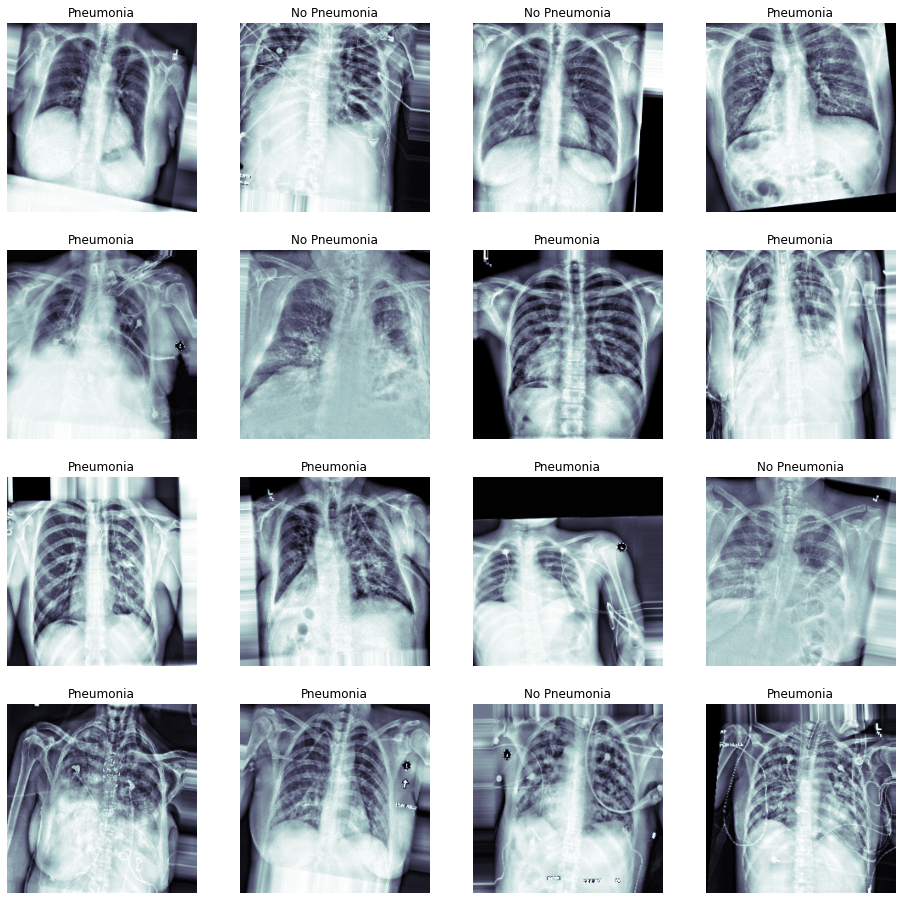

In [59]:
## May want to look at some examples of our augmented training data.
## This is helpful for understanding the extent to which data is being manipulated prior to training,
## and can be compared with how the raw data look prior to augmentation

trainX, trainY = next(train_gen)
visualization.batch_image_peak(trainX, trainY)

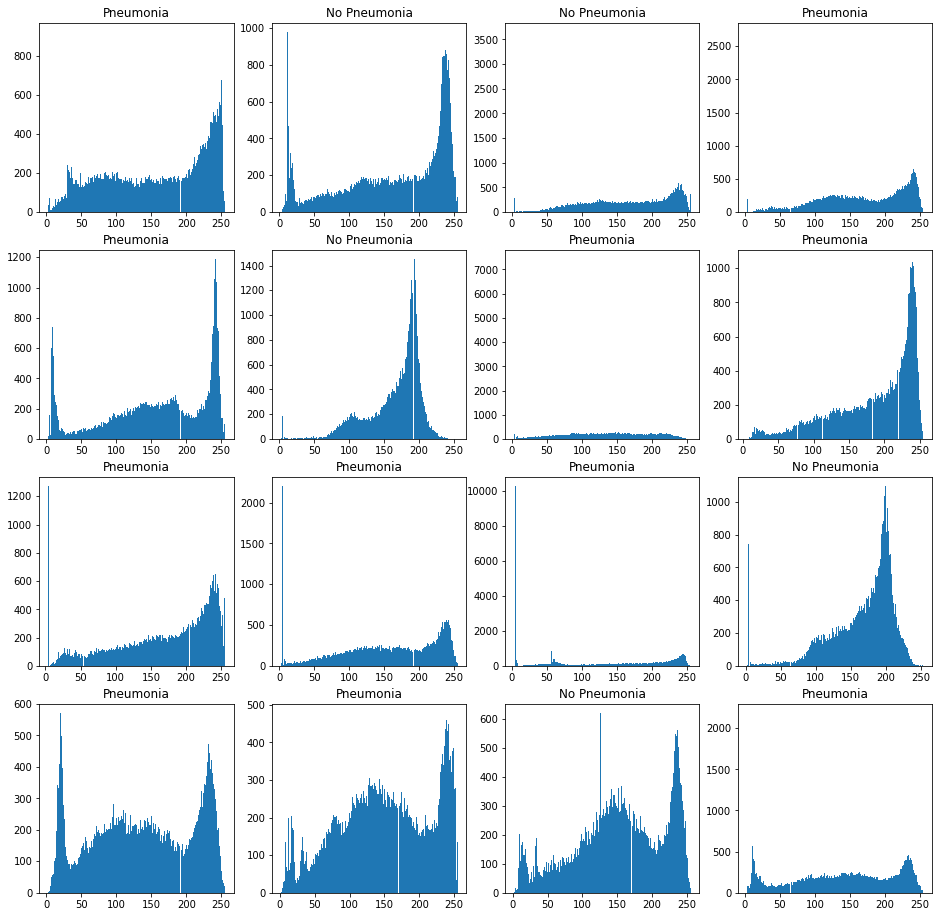

In [60]:
visualization.batch_histogram_peak(trainX, trainY)

#### Validation-set images


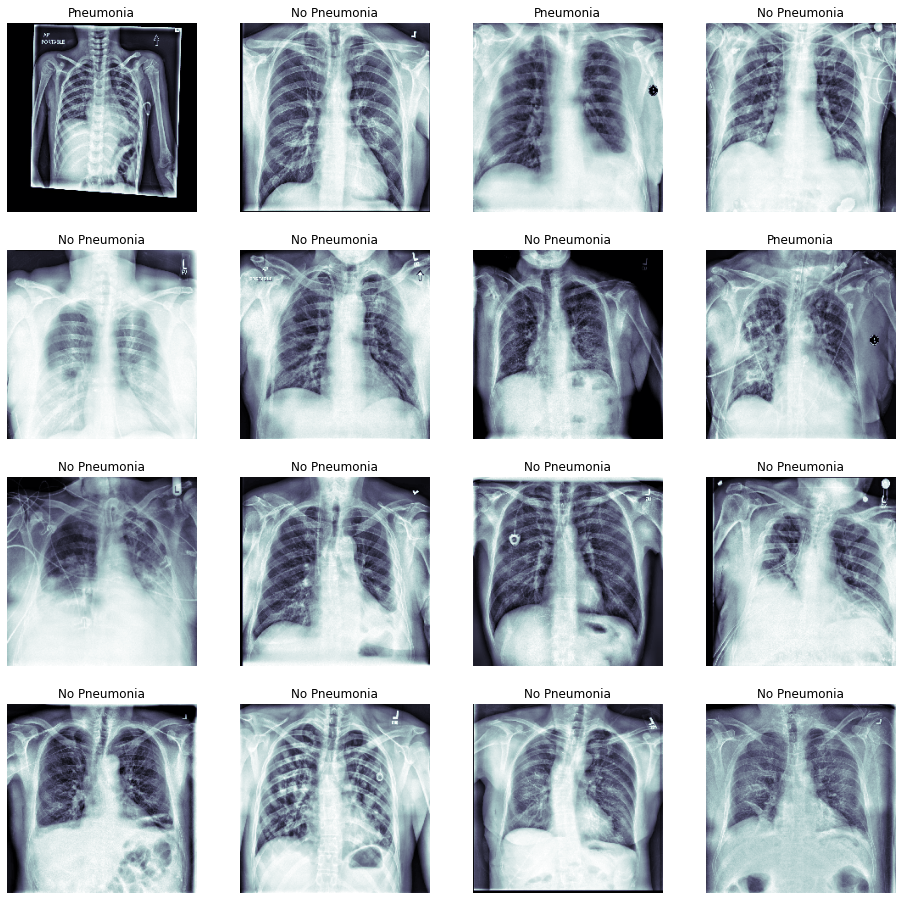

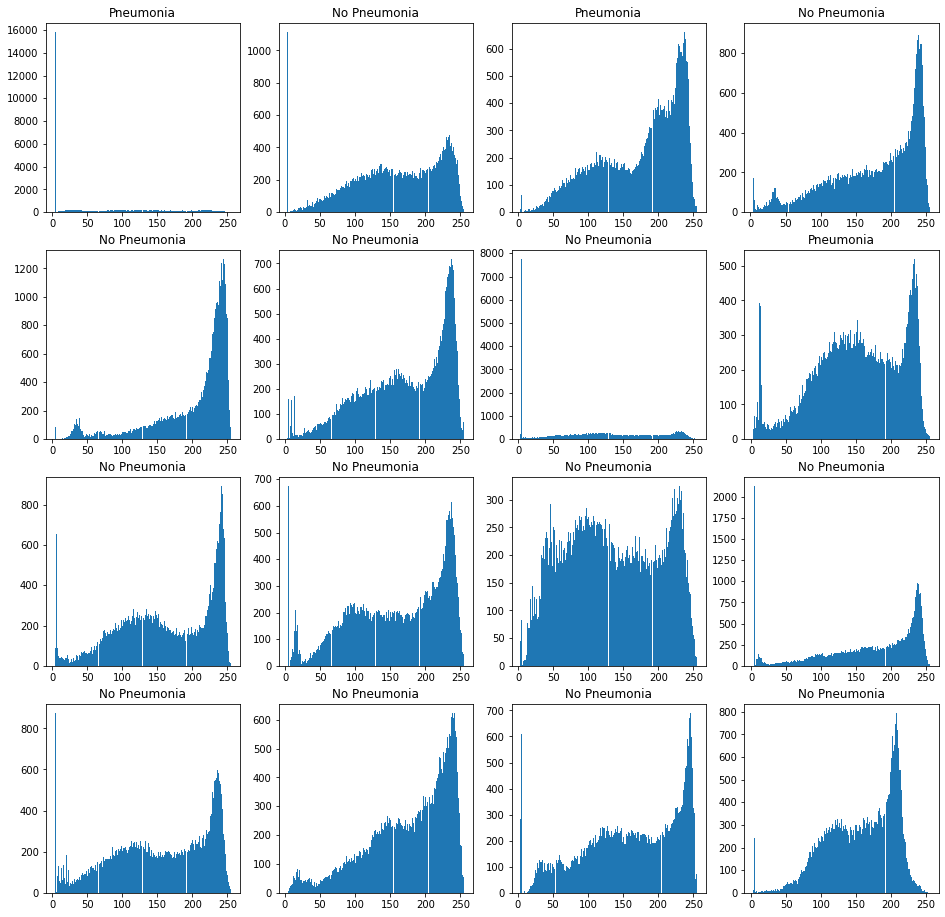

In [61]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
visualization.batch_image_peak(valX, valY)
visualization.batch_histogram_peak(valX, valY)

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning


In [62]:
DropoutFactor = 0.5
WeightDecay = 1e-6

inputs = tf.keras.Input(shape=INPUT_SHAPE)

pre_trained = models.VGG16(INPUT_SHAPE)
# pre_trained = models.ResNet50(INPUT_SHAPE)
preprocessing = pre_trained.get_preprocessing()
# load pre-trained model
base_model = pre_trained.get_base_model()
base_model.trainable = False

x = preprocessing(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten(name='Flatten')(x)
x = tf.keras.layers.Dropout(DropoutFactor)(x)
x = tf.keras.layers.Dense(256, name='FC1', activation='relu')(x)
outputs = tf.keras.layers.Dense(1, name='prediction', activation='sigmoid')(x)
my_model = tf.keras.Model(inputs, outputs)

print(my_model.summary())
for layer in my_model.layers:
    print(f'{layer.name}: {layer.trainable}')

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
VGG16_preprocessing (Sequent (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
Flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               6422784   
_________________________________________________________________
prediction (Dense)           (None, 1)                 257 

In [63]:
PATIENCE = 15

METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_loss'
EVALUATION_MODE = 'auto'

weight_path = "{}.best.hdf5".format('warmup')

checkpoint = ModelCheckpoint(weight_path,
                             monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                             verbose=1,
                             save_best_only=True,
                             mode=EVALUATION_MODE,
                             save_weights_only=False)

early = EarlyStopping(monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                      mode=EVALUATION_MODE,
                      patience=PATIENCE)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='log/', histogram_freq=1)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                                                 factor=0.1,
                                                 patience=5,
                                                 verbose=1,
                                                 mode='auto')

callbacks_list = [checkpoint, early, tensorboard_callback, reduce_LR]

2021-11-10 16:44:42.119261: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-10 16:44:42.119365: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-10 16:44:42.341991: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-10 16:44:42.342094: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [64]:
# Compile the model!
optimizer = Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy()]

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Start training!

In [19]:
## train your model
MAX_EPOCHS = 50

history = my_model.fit(train_gen,
                       validation_data=val_gen,
                       epochs=MAX_EPOCHS,
                       class_weight=class_weight,
                       steps_per_epoch=steps_per_epoch,
                       validation_steps=validation_steps,
                       callbacks=callbacks_list
                       )

2021-11-08 11:05:33.715123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-08 11:05:35.549381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-08 11:05:36.338772: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-08 11:05:36.549168: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2021-11-08 11:05:37.853361: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is 

 1/43 [..............................] - ETA: 9:04 - loss: 1.9370 - binary_accuracy: 0.4688

2021-11-08 11:05:46.719498: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-08 11:05:46.719525: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/43 [>.............................] - ETA: 22s - loss: 2.4049 - binary_accuracy: 0.4531 

2021-11-08 11:05:47.251705: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-08 11:05:47.252218: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-08 11:05:47.284754: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 161 callback api events and 158 activity events. 
2021-11-08 11:05:47.288363: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-08 11:05:47.299004: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/profile/2021_11_08_11_05_47

2021-11-08 11:05:47.301266: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/train/plugins/profile/2021_11_08_11_05_47/perrusi-PC.trace.json.gz
2021-11-08 11:05:47.312413: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/p

30/43 [===================>..........] - ETA: 6s - loss: 2.4285 - binary_accuracy: 0.5073 

2021-11-08 11:06:00.991865: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-08 11:06:00.991946: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-08 11:06:01.088599: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


43/43 [==============================] - ETA: 0s - loss: 2.4462 - binary_accuracy: 0.5036

2021-11-08 11:06:15.361942: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


43/43 [==============================] - 92s 2s/step - loss: 2.4462 - binary_accuracy: 0.5036 - val_loss: 2.5086 - val_binary_accuracy: 0.5748

Epoch 00001: val_loss improved from inf to 2.50860, saving model to warmup.best.hdf5
Epoch 2/50
43/43 [==============================] - 43s 1s/step - loss: 2.2213 - binary_accuracy: 0.5124 - val_loss: 2.4350 - val_binary_accuracy: 0.5868

### Fine-tunning

In [65]:
my_model.load_weights(weight_path)  # load early stopped weights

In [66]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_top_layers = pre_trained.get_fine_tuning_top_layer()

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-fine_tune_top_layers]:
    layer.trainable = False
for layer in base_model.layers[-fine_tune_top_layers:]:
    layer.trainable = True

my_model.summary()
print(len(my_model.trainable_variables))

Number of layers in the base model:  19
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
VGG16_preprocessing (Sequent (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
Flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               6422784   
_________________________________________________________________
prediction (Dense) 

In [67]:
# reset generators
train_gen.reset()
val_gen.reset()

# re-compile the model with a smaller learning rate
optimizer = Adam(learning_rate=1e-6)
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

weight_path = "{}.best.hdf5".format('fine_tunning')
checkpoint = ModelCheckpoint(weight_path,
                             monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                             verbose=1,
                             save_best_only=True,
                             mode=EVALUATION_MODE,
                             save_weights_only=False)

callbacks_list = [checkpoint, early, tensorboard_callback, reduce_LR]

In [23]:
## re-train your model
MAX_FINE_TUNED_EPOCHS = history.epoch[-1] + 50

history_fine = my_model.fit(train_gen,
                            validation_data=val_gen,
                            initial_epoch=history.epoch[-1],
                            epochs=MAX_FINE_TUNED_EPOCHS,
                            callbacks=callbacks_list,
                            class_weight=class_weight,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            )

Epoch 50/99
 1/43 [..............................] - ETA: 1:53 - loss: 0.5159 - binary_accuracy: 0.6770

2021-11-08 11:45:26.345761: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-08 11:45:26.345780: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/43 [>.............................] - ETA: 26s - loss: 0.5452 - binary_accuracy: 0.6762 

2021-11-08 11:45:27.033140: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-08 11:45:27.033422: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-08 11:45:27.090241: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 255 callback api events and 254 activity events. 
2021-11-08 11:45:27.094927: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-08 11:45:27.100492: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/profile/2021_11_08_11_45_27

2021-11-08 11:45:27.103839: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/train/plugins/profile/2021_11_08_11_45_27/perrusi-PC.trace.json.gz
2021-11-08 11:45:27.113932: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/p

43/43 [==============================] - 45s 999ms/step - loss: 0.4797 - binary_accuracy: 0.6516 - val_loss: 0.6105 - val_binary_accuracy: 0.6796

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [68]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)

In [69]:
# Use model for inference on each dataset
train_gen.reset()
val_gen.reset()
fda_gen.reset()

train_predY = my_model.predict(train_gen, batch_size=TRAINING_BATCH, verbose=True)
val_predY = my_model.predict(val_gen, batch_size=VALIDATION_BATCH, verbose=True)
fda_predY = my_model.predict(fda_gen, batch_size=VALIDATION_BATCH, verbose=True)


351/351 [==============================] - 262s 748ms/step

In [26]:
# Evaluate model for each dataset
train_gen.reset()
val_gen.reset()
fda_gen.reset()

train_eval = my_model.evaluate(train_gen, batch_size=TRAINING_BATCH, verbose=True)
val_eval = my_model.evaluate(val_gen, batch_size=VALIDATION_BATCH, verbose=True)
fda_eval = my_model.evaluate(fda_gen, batch_size=VALIDATION_BATCH, verbose=True)


351/351 [==============================] - 241s 685ms/step - loss: 0.5112 - binary_accuracy: 0.7770

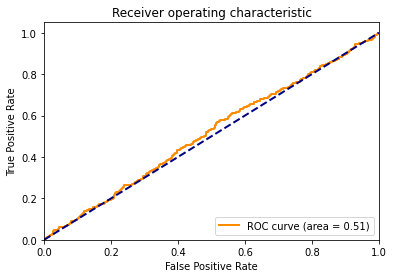

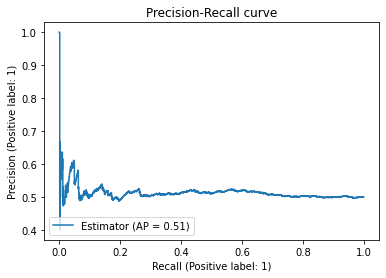

In [70]:
## plot performance metrics
visualization.plot_auc(train_gen.labels, train_predY)
visualization.precision_recall(train_gen.labels, train_predY)

In [ ]:
visualization.plot_history_fine(history, history_fine)


Now let's choose a threshold with desired precision/recall balance based on the training data

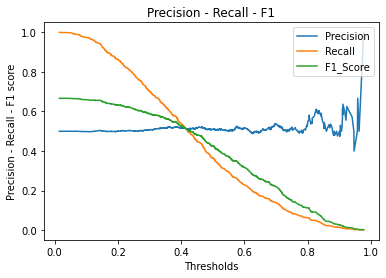

In [76]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(train_gen.labels, train_predY)
f1_scores = tools.compute_f1(precision, recall)
precision = tools.remove_nan(precision)
recall = tools.remove_nan(recall)
thresholds = tools.remove_nan(thresholds)
f1_scores = tools.remove_nan(f1_scores)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1_Score')
plt.xlabel('Thresholds')
plt.ylabel('Precision - Recall - F1 score')
plt.title("Precision - Recall - F1")
plt.legend(['Precision', 'Recall', 'F1_Score'], loc='upper right')
plt.show()

For threshold 0.24, F1 score 0.62, precision 0.50, recall 0.80


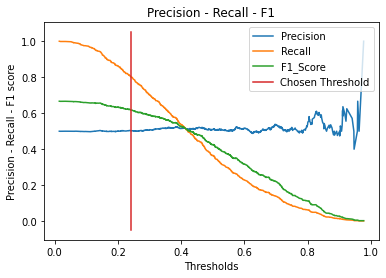

In [85]:
# idx = np.argmax(f1_scores[:-1])
# idx = np.argmax(precision[:-1])
# idx = np.argmax(recall[:-1])
# idx = tools.find_nearest_idx(f1_scores, 0.6)
idx = tools.find_nearest_idx(recall, 0.8)
# idx = tools.find_nearest_idx(thresholds, 0.62)

threshold = thresholds[idx]

print(f'For threshold {threshold:.2f}, F1 score {f1_scores[idx]:.2f}, precision {precision[idx]:.2f}, recall {recall[idx]:.2f}')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1_Score')
plt.plot([threshold, threshold], plt.ylim(), label='Chosen Threshold')
plt.xlabel('Thresholds')
plt.ylabel('Precision - Recall - F1 score')
plt.title("Precision - Recall - F1")
plt.legend(['Precision', 'Recall', 'F1_Score', 'Chosen Threshold'], loc='upper right')
plt.show()

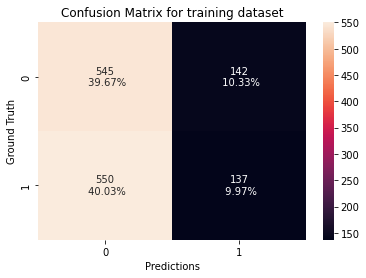

In [86]:
visualization.confusion_matrix(train_gen.labels, train_predY < threshold)
plt.title('Confusion Matrix for training dataset')
plt.show()

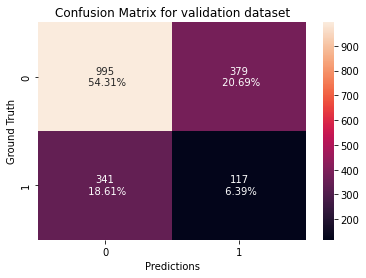

In [87]:
visualization.confusion_matrix(val_gen.labels, val_predY < threshold)
plt.title('Confusion Matrix for validation dataset')
plt.show()


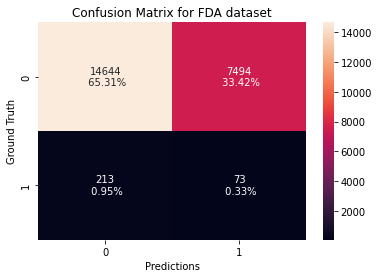

In [88]:
# Apply it to the FDA set
visualization.confusion_matrix(fda_gen.labels, fda_predY < threshold)
plt.title('Confusion Matrix for FDA dataset')
plt.show()

In [151]:
## Just save model architecture to a .json:

my_model.save("my_model.h5")

In [152]:
import json

# Save it under the form of a json file
# json.dump(history.history, open('history.json', 'w'))
# json.dump(history_fine.history, open('history_fine.json', 'w'))

### References
* https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

